In [1]:
import torch
import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
import anndata as ad
import harmonypy as hm
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA
import iSp3D as MODEL
from iSp3D import Func
from iSp3D import Metrics

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.2'
os.environ['R_USER'] = r'C:\Users\CLEARLOVE\.conda\envs\STG\Lib\site-packages\rpy2'

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]

    LISI = 2 * (1 / LISI_domain_norm) * LISI_batch_norm / (1 / LISI_domain_norm + LISI_batch_norm)
    return LISI

c:\Users\CLEARLOVE\.conda\envs\STG\lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
c:\Users\CLEARLOVE\.conda\envs\STG\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
c:\Users\CLEARLOVE\.conda\envs\STG\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
c:\Users\CLEARLOVE\.conda\envs\STG\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
c:\Users\CLEARLOVE\.conda\envs\ST

In [2]:
ROOT_PATH = Path(r'C:\Code\Data\ST Adult mouse brain section A\MBA-MBP2')
DATA_NAME = 'Mouse_Brain_Anterior'
adata_anterior = sc.read_visium(ROOT_PATH / 'Mouse_Brain_Anterior_2', count_file=DATA_NAME + "_2_filtered_feature_bc_matrix.h5")
adata_anterior.var_names_make_unique()

spatial_a=pd.read_csv(r"C:\Code\Data\ST Adult mouse brain section A\MBA-MBP2/Mouse_Brain_Anterior_2/spatial/tissue_positions_list.csv",
                    sep=",",header=None,na_filter=False,index_col=0)
adata_anterior.obs["x_array"]=spatial_a[2]
adata_anterior.obs["y_array"]=spatial_a[3]
adata_anterior.obs["x_pixel"]=spatial_a[4]
adata_anterior.obs["y_pixel"]=spatial_a[5]
adata_anterior.obs['boundary'] = 0
# adata_anterior.obs['x_pixel'] = adata_anterior.obsm['spatial'][:,0]
# adata_anterior.obs['y_pixel'] = adata_anterior.obsm['spatial'][:,1]
# make spot name unique
adata_anterior.obs_names = [x + '_anterior' for x in adata_anterior.obs_names]

# adata_anterior.layers['count'] = adata_anterior.X.toarray()
# sc.pp.normalize_total(adata_anterior, target_sum=1e6)
# sc.pp.highly_variable_genes(adata_anterior, flavor="seurat_v3", layer='count', n_top_genes=5000)
# adata_anterior = adata_anterior[:, adata_anterior.var['highly_variable'] == True]
# sc.pp.scale(adata_anterior)
# adata_anterior = adata_anterior[:, adata_anterior.var['highly_variable']]
adata_anterior

AnnData object with n_obs × n_vars = 2825 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'boundary'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
DATA_NAME = 'Mouse_Brain_Posterior'
adata_posterior = sc.read_visium(ROOT_PATH / 'Mouse_Brain_Posterior_2', count_file=DATA_NAME + "_2_filtered_feature_bc_matrix.h5")
adata_posterior.var_names_make_unique()

spatial_p=pd.read_csv(r"C:\Code\Data\ST Adult mouse brain section A\MBA-MBP2/Mouse_Brain_Posterior_2/spatial/tissue_positions_list.csv",
                    sep=",",header=None,na_filter=False,index_col=0)
adata_posterior.obs["x_array"]=spatial_p[2]
adata_posterior.obs["y_array"]=spatial_p[3]
adata_posterior.obs["x_pixel"]=spatial_p[4]
adata_posterior.obs["y_pixel"]=spatial_p[5]
adata_posterior.obs['boundary'] = 0
# adata_posterior.obs['x_pixel'] = adata_posterior.obsm['spatial'][:,0]
# adata_posterior.obs['y_pixel'] = adata_posterior.obsm['spatial'][:,1]
# make spot name unique
adata_posterior.obs_names = [x + '_posterior' for x in adata_posterior.obs_names]

# adata_posterior.layers['count'] = adata_posterior.X.toarray()
# sc.pp.normalize_total(adata_posterior, target_sum=1e6)
# sc.pp.highly_variable_genes(adata_posterior, flavor="seurat_v3", layer='count', n_top_genes=5000)
# adata_posterior = adata_posterior[:, adata_posterior.var['highly_variable'] == True]
# sc.pp.scale(adata_posterior)
# adata_posterior = adata_posterior[:, adata_posterior.var['highly_variable']]
adata_posterior

AnnData object with n_obs × n_vars = 3289 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'boundary'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
obs_a = adata_anterior.obs
obs_p = adata_posterior.obs
# obs_p["x_pixel"]=obs_p["x_pixel"]-np.min(obs_p["x_pixel"])+np.min(obs_a["x_pixel"])
obs_p["y_pixel"] = obs_p["y_pixel"] - np.min(obs_p["y_pixel"]) + np.max(obs_a["y_pixel"]) - 150
# obs_p["y_pixel"] = obs_p["y_pixel"] - np.min(obs_p["y_pixel"]) + np.max(obs_a["y_pixel"]) + 1500

obs_a["boundary"] = 0
obs_p["boundary"] = 0

for i in list(set(obs_a['x_array'])):
    j = obs_a[obs_a['x_array'] == i].max()["y_array"]
    temp = obs_a[obs_a['x_array'] == i]
    temp = temp[temp['y_array'] == j].index
    obs_a.loc[temp, "boundary"] = 1

for i in list(set(obs_p['x_array'])):
    j = obs_p[obs_p['x_array'] == i].min()["y_array"]
    temp = obs_p[obs_p['x_array'] == i]
    temp = temp[temp['y_array'] == j].index
    obs_p.loc[temp, "boundary"] = 1

mean_a_y = obs_a[obs_a["boundary"] == 1]['x_pixel'].mean()
mean_p_y = obs_p[obs_p["boundary"] == 1]['x_pixel'].mean()
obs_p['x_pixel'] = obs_p['x_pixel'] + mean_a_y - mean_p_y

In [5]:
adata_anterior.obsm["spatial_aligned"] = adata_anterior.obs.loc[adata_anterior.obs_names, ['x_pixel', "y_pixel"]].to_numpy()
adata_posterior.obsm["spatial_aligned"] = adata_posterior.obs.loc[adata_posterior.obs_names, ['x_pixel', "y_pixel"]].to_numpy()

In [6]:
list_adata = [adata_anterior, adata_posterior]

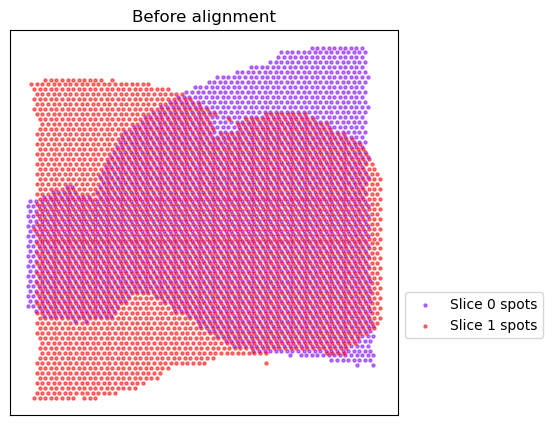

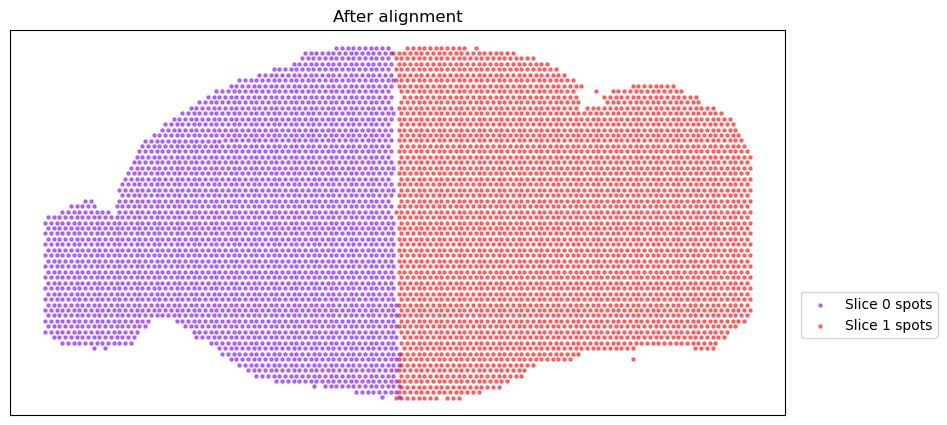

In [7]:
plot = True
coor_key = "spatial"
if plot:
    from matplotlib import cm
    import matplotlib
    import matplotlib.pyplot as plt

    # Choose colors
    cmap = cm.get_cmap('rainbow', len(list_adata))
    colors_list = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(len(list_adata))]

    # Plot spots before alignment
    plt.figure(figsize=(5, 5))
    plt.title("Before alignment")
    for i in range(len(list_adata)):
        plt.scatter(list_adata[i].obsm[coor_key][:, 0],
                    list_adata[i].obsm[coor_key][:, 1],
                    c=colors_list[i],
                    label="Slice %d spots" % i, s=5., alpha=0.5)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc=(1.02, .2), ncol=(len(list_adata) // 13 + 1))
    plt.show()

if plot:
    plt.figure(figsize=(10, 5))
    plt.title("After alignment")
    for i in range(len(list_adata)):
        plt.scatter(list_adata[i].obsm["spatial_aligned"][:, 1],
                    list_adata[i].obsm["spatial_aligned"][:, 0],
                    c=colors_list[i],
                    label="Slice %d spots" % i, s=5., alpha=0.5)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc=(1.02, .2), ncol=(len(list_adata) // 13 + 1))
    plt.show()

In [8]:
import anndata as ad
pre_adata = ad.concat(list_adata, label="batch_name", keys=['anterior', 'posterior'])
pre_adata.obs["batch_name"] = pre_adata.obs["batch_name"].astype('category')
pre_adata

AnnData object with n_obs × n_vars = 6114 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'boundary', 'batch_name'
    obsm: 'spatial', 'spatial_aligned'

In [9]:
slice_name_list = list(pre_adata.obs['batch_name'].unique())
slice_name_list

['anterior', 'posterior']

In [ ]:
with open(r"C:\Code\iSpa3D\Config\Config_SMB.yaml", 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [11]:
result, mapping = mapping2int(slice_name_list)

for i, proj_name in enumerate(slice_name_list):

    adata_tmp = pre_adata[pre_adata.obs['batch_name'] == slice_name_list[i]]
    adata_tmp.obs['slice_id'] = mapping[proj_name]
    graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['data']['k_cutoff'])

    ##### Load layer_guess label, if have
    # df_label = pd.read_csv(data_root / proj_name / 'manual_annotations.txt', sep='\t', header=None, index_col=0)
    # df_label.columns = ['layer_guess']
    # adata_tmp.obs['layer_guess'] = df_label['layer_guess']
    #adata_tmp= adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]

    if proj_name == slice_name_list[0]:
        adata = adata_tmp
        graph_dict = graph_dict_tmp
        name = proj_name
        adata.obs['proj_name'] = proj_name
    else:
        var_names = adata.var_names.intersection(adata_tmp.var_names)
        adata = adata[:, var_names]
        adata_tmp = adata_tmp[:, var_names]
        adata_tmp.obs['proj_name'] = proj_name

        adata = adata.concatenate(adata_tmp)
        graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
        name = name + '_' + proj_name

In [12]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['data']['top_genes'])
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable.
adata.obsm['X_original'] = adata.X.copy()
pca = PCA(n_components=200, random_state=42)
adata_X = pca.fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [13]:
num_cluster = config['model']['class_num']
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [14]:
method = 'mclust'

In [15]:
net.train(method=method)

Epoch 295 total loss=4.466 recon loss=0.395 tri loss=0.000 disc loss=0.454 cluster loss=4.143:  50%|████▉     | 298/600 [00:11<00:10, 29.72it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Epoch 345 total loss=4.480 recon loss=0.398 tri loss=0.119 disc loss=0.471 cluster loss=4.115:  58%|█████▊    | 350/600 [00:32<00:15, 16.37it/s]

fitting ...
  |======================================================================| 100%


Epoch 395 total loss=4.373 recon loss=0.384 tri loss=0.097 disc loss=0.456 cluster loss=4.026:  67%|██████▋   | 400/600 [00:49<00:11, 16.72it/s]

fitting ...
  |===================================                                   |  50%

Epoch 395 total loss=4.373 recon loss=0.384 tri loss=0.097 disc loss=0.456 cluster loss=4.026:  67%|██████▋   | 400/600 [01:00<00:11, 16.72it/s]

  |======================================================================| 100%


Epoch 445 total loss=4.253 recon loss=0.390 tri loss=0.103 disc loss=0.448 cluster loss=3.904:  75%|███████▍  | 449/600 [01:16<00:10, 15.06it/s]

fitting ...
  |======================================================================| 100%


Epoch 495 total loss=4.187 recon loss=0.398 tri loss=0.104 disc loss=0.450 cluster loss=3.831:  83%|████████▎ | 499/600 [01:31<00:06, 15.81it/s]

fitting ...
  |======================================================================| 100%


Epoch 545 total loss=4.142 recon loss=0.376 tri loss=0.093 disc loss=0.444 cluster loss=3.798:  92%|█████████▏| 550/600 [01:52<00:03, 15.31it/s]

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=4.086 recon loss=0.367 tri loss=0.106 disc loss=0.443 cluster loss=3.739: 100%|██████████| 600/600 [02:08<00:00,  4.67it/s]


In [16]:
def inverse_pca_transform(pca, recon_pca_data):
    recon_original = pca.inverse_transform(recon_pca_data)
    return recon_original

In [17]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
recon_original = inverse_pca_transform(pca, recon)
adata.obsm['X_reconstructed'] = recon_original

print(adata)

AnnData object with n_obs × n_vars = 6114 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'boundary', 'batch_name', 'slice_id', 'proj_name', 'batch', 'Tmp_domain'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'spatial_aligned', 'X_original', 'X_pca', 'latent', 'recon', 'X_reconstructed'
    layers: 'count'


In [18]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

fitting ...
  |======================================================================| 100%


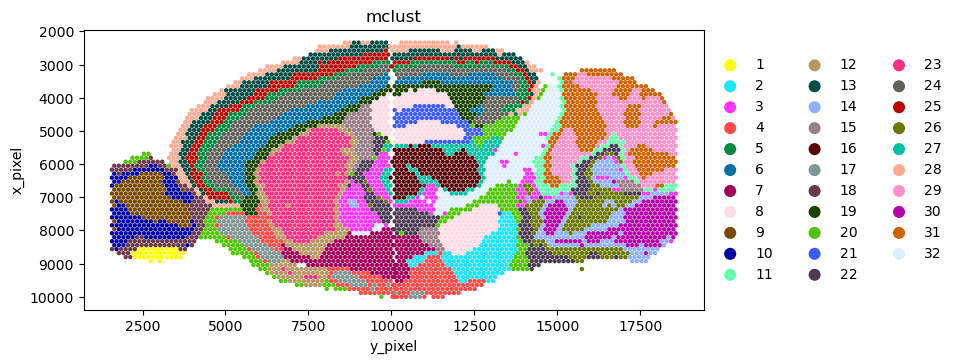

In [19]:
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'white'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'white'  # 设置整张图的背景颜色
plt.rcParams['savefig.bbox'] = 'tight'  # 保存时自动调整边界

# 数据预处理
subadata = adata[~adata.obs['mclust'].isna()]  # 删除 NaN

# 创建图形
fig, ax = plt.subplots(figsize=(8, 8))  # 可以调整图形大小

# 绘制散点图
sc.pl.scatter(
    subadata,
    alpha=1,
    x="y_pixel",
    y="x_pixel",
    color="mclust",
    show=False,
    size=40,
    ax=ax
)

# 设置坐标轴属性
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.grid(False)

In [20]:
from iSp3D.Classifier import iSpaNetClassifier

with open('C:\\Code\\iSpa3D\\Config\\classifier_config.yaml', 'r', encoding='utf-8') as f:
    classifier_config = yaml.load(f.read(), Loader=yaml.FullLoader)
    
cluster_labels_original = adata.obs['mclust'].values.astype(int)
 
unique_labels = np.unique(cluster_labels_original)
label_mapping = {old: new for new, old in enumerate(sorted(unique_labels))}
cluster_labels_for_training = np.array([label_mapping[label] for label in cluster_labels_original])


classifier = iSpaNetClassifier(in_features=config['model']['latent_dim'], n_classes=len(unique_labels), config=classifier_config, device=device)
classifier.prepare_data(g3net_model=net, adata=adata, target_labels=cluster_labels_for_training)
classifier.train(epochs=classifier.max_epochs, verbose=True, early_stop_patience=50)

Epoch [ 10/300] Train Loss: 1.2378, Train Acc: 0.5853 | Val Loss: 0.8212, Val Acc: 0.8036
Epoch [ 20/300] Train Loss: 1.0128, Train Acc: 0.6157 | Val Loss: 0.6393, Val Acc: 0.8331
Epoch [ 30/300] Train Loss: 0.9677, Train Acc: 0.6300 | Val Loss: 0.5796, Val Acc: 0.8183
Epoch [ 40/300] Train Loss: 0.9250, Train Acc: 0.6462 | Val Loss: 0.5638, Val Acc: 0.8347
Epoch [ 50/300] Train Loss: 0.9039, Train Acc: 0.6526 | Val Loss: 0.5406, Val Acc: 0.8396
Epoch [ 60/300] Train Loss: 0.8926, Train Acc: 0.6600 | Val Loss: 0.5385, Val Acc: 0.8543
Epoch [ 70/300] Train Loss: 0.8965, Train Acc: 0.6651 | Val Loss: 0.5259, Val Acc: 0.8592
Epoch [ 80/300] Train Loss: 0.8720, Train Acc: 0.6715 | Val Loss: 0.5350, Val Acc: 0.8429
Epoch [ 90/300] Train Loss: 0.8627, Train Acc: 0.6715 | Val Loss: 0.5450, Val Acc: 0.8592
Epoch [100/300] Train Loss: 0.8554, Train Acc: 0.6675 | Val Loss: 0.5369, Val Acc: 0.8265
Epoch [110/300] Train Loss: 0.8781, Train Acc: 0.6667 | Val Loss: 0.5323, Val Acc: 0.8527
Epoch [120

In [21]:
from iSp3D.Attribution import compute_and_summary_by_cluster

res_df = compute_and_summary_by_cluster(
    net=net,
    cluster_key='mclust',  
    classifier=classifier,
    batch_size=64,
    top_k=100,
    pca=pca, 
    target_clusters=['1','15'],
    normalize= True,
    max_baselines=3,
    spatial_radius=500
)

Computing attributions for 2 clusters...


Cluster attribution:   0%|          | 0/2 [00:00<?, ?it/s]

Cluster 1: neighbors = ['18', '10']


Cluster attribution:  50%|█████     | 1/2 [00:16<00:16, 16.56s/it]

Cluster 15: neighbors = ['8', '22']


Cluster attribution: 100%|██████████| 2/2 [00:32<00:00, 16.47s/it]


In [22]:
final_dfs, top_dict, per_method_dfs = res_df
for cluster_label in sorted(final_dfs.keys()):
    obj = final_dfs[cluster_label]
    
    if isinstance(obj, pd.DataFrame):
        sort_col = 'final_score' if 'final_score' in obj.columns else ('diff' if 'diff' in obj.columns else None)
        if sort_col:
            genes = obj.sort_values(sort_col, ascending=False).head(20).index.tolist()
        else:
            genes = obj.index[:20].tolist()
    else:
        genes = list(obj)[:20]
    
    print(f"Cluster {cluster_label}: {genes}")

Cluster 1: ['Cplx1', 'Nefl', 'Spp1', 'Lgi2', 'Vamp1', 'Atp1a2', 'Slc24a2', 'Nefh', 'Pvalb', 'Nefm', 'Aldoc', 'Thy1', 'Dtl', 'Slc30a3', 'Klhdc8a', 'Efr3a', 'Tox3', 'Tnnt1', 'Adra1b', 'Cdkl4']
Cluster 15: ['Ttr', 'Enpp2', 'Kl', 'Ecrg4', '2900040C04Rik', 'Sostdc1', 'F5', 'Clic6', 'Slc4a5', 'Folr1', 'Tmem72', 'Prr32', 'Kcne2', 'Sulf1', 'Cldn2', 'Trpv4', 'Car12', 'Calb2', 'Spint2', 'Prlr']


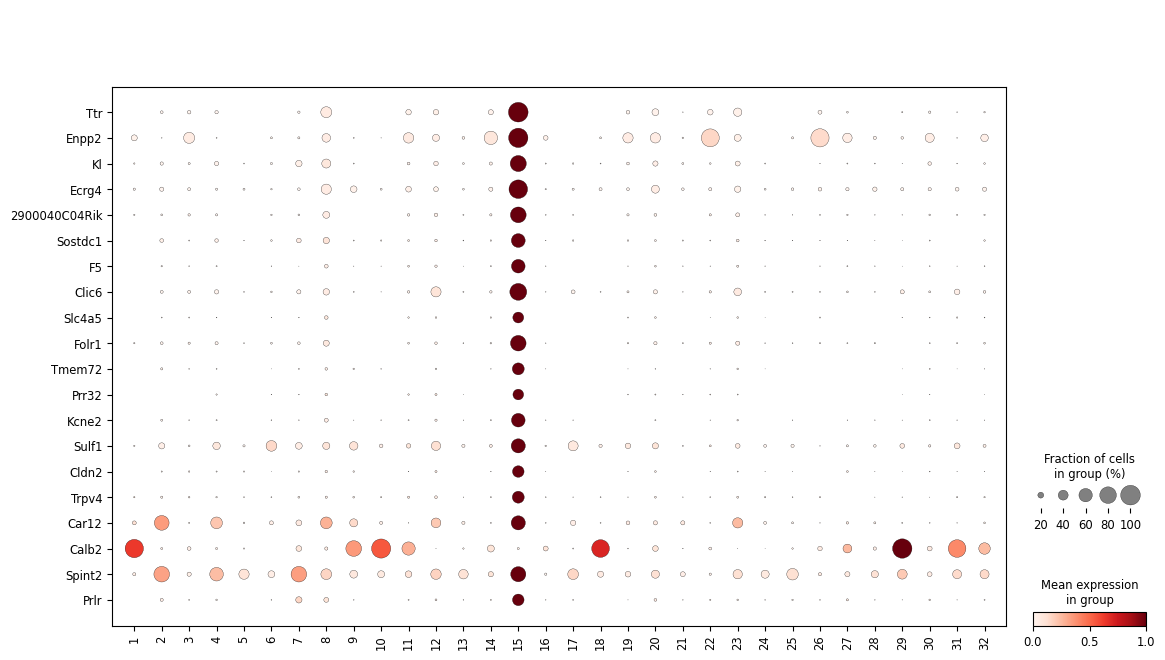

In [25]:
adata.obs['re_mclust'] = adata.obs['mclust'].astype(str)

dg =  ['Ttr', 'Enpp2', 'Kl', 'Ecrg4', '2900040C04Rik', 'Sostdc1', 'F5', 'Clic6', 'Slc4a5', 'Folr1', 'Tmem72', 'Prr32', 'Kcne2', 'Sulf1', 'Cldn2', 'Trpv4', 'Car12', 'Calb2', 'Spint2', 'Prlr']
sc.pl.dotplot(adata, dg, groupby='re_mclust', dendrogram=None, swap_axes=True, standard_scale='var', show=False)
plt.show()